# **Reinforcement Learning**
<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:

```sh
!pip uninstall gym -y
!pip install gym
```
<br>

And here is gymnasium version:

```python
gymnasium.__version__
```
1.2.0

<br>

<center><img src="https://media.tenor.com/zOoVaNGp6IsAAAAd/mario-game.gif"><center>

In [ ]:
!pip install swig
!pip install gymnasium[atari]
!pip install gymnasium[box2d]
!pip install gymnasium[accept-rom-license]
# !pip install autorom[accept-rom-license]

In [2]:
import random
import copy
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.core.display import HTML, clear_output
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

import torch
from torch import nn

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import warnings
warnings.filterwarnings('ignore')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
def display_video(episode=0, video_width=600):
    """
    Displays a video from a specified episode with customizable width.

    Args:
        episode (int): The episode number to load the video for. Defaults to 0.
        video_width (int): The width of the video player in pixels. Defaults to 600.

    Returns:
        IPython.display.HTML: An HTML video element that can be rendered in Jupyter notebooks.

    Note:
        - The function expects video files to be in './video/' directory with naming format 'rl-video-episode-{N}.mp4'
        - Videos are base64 encoded and embedded directly in the HTML for display
    """
    # Construct the path to the video file based on episode number
    video_path = f"./video/rl-video-episode-{episode}.mp4"

    # Read the video file as binary data
    video_file = open(video_path, "rb").read()

    # Encode the binary video data as base64 string
    decoded = b64encode(video_file).decode()

    # Create a data URL for the video
    video_url = f"data:video/mp4;base64,{decoded}"

    # Return an HTML video element with the embedded video
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode=None, record=False, eps_record=50, video_folder='./video'):
    """
    Creates and configures a Gym environment with optional video recording and statistics tracking.

    Args:
        name (str): Name of the Gym environment to create (e.g., 'CartPole-v1')
        render_mode (str): Rendering mode - "human", "rgb_array", or "ansi".
                                Defaults to None for faster training, for recording use "rgb_array"
        record (bool): Whether to record videos of the environment. Defaults to False
        eps_record (int): Record a video every N episodes (when record=True). Defaults to 50
        video_folder (str): Directory to save recorded videos. Defaults to './video'

    Returns:
        gym.Env: Configured Gym environment wrapped with recording and statistics tracking

    Note:
        - When record=True, videos will be saved in the specified folder with automatic naming
        - The environment is always wrapped with episode statistics tracking
    """
    # Create base Gym environment with specified render mode
    env = gym.make(name, render_mode=render_mode)

    # Optionally wrap environment with video recorder
    if record:
        # Record video every eps_record episodes (trigger function)
        env = RecordVideo(env, video_folder=video_folder,
                         episode_trigger=lambda x: x % eps_record == 0)

    # Always wrap environment with episode statistics tracker
    env = RecordEpisodeStatistics(env)

    return env

## **Deep Deterministic Policy (DDP)**

- **DQN downsides:**
    1. Continuous space: how would you take the max of $Q$
    2. Learning wrong objective: we want optimal policy; however, in this method we find optimal $Q$
    3. Instability: it doesn't guarantee to converge
    4. Deterministic Policy: we need stochastic policy

- **Policy gradient downsides:**
    1. we can't use replay buffer
    2. target network


<br>


### **Approach:**

We have two network:

1. Actor: parameterized by $\theta$ and learn policy that take states $s$ then produces actions: $a=\mu_\theta(s)$, so this would maximizes $Q(s, a)$:

$$
\underset{a'}{\text{max}} Q^*(s', a') \approx Q^*(s', \mu_\theta(s))
$$

2. Critic: parameterized by $\pi$ and learn Q network that take states $s$ and actions from actor: $a=\mu_\theta(s)$ then produces $Q$ values $Q_\phi(s, μ_\theta(s))$.

<br>

- **exploration:** to explore environment during the game, when we want to take an action while playing we will add a bit of randomness $\epsilon$ using guassian distribution: $\epsilon \sim N(0, \sigma^2)$

$$
\large \epsilon_t = \epsilon_0 \cdot \exp(-\lambda t)
$$

> $\epsilon_0$ is the initial noise level.<br>
$\lambda$ controls the rate of decay.<br>
$t$ is the training step or episode.

<br>

- **target network:** polyak averaging (exponential averaging):

$$
\large \phi_{\text{target}} ← \tau \phi_{\text{target}} + (1 - \tau) \phi
$$

> $\tau = 0.995$, we do this every update step

<br>

### **Q-learning: Critic**

Loss Functions: Ensure that the critic loss uses the Bellman equation:

- **MSE Loss:**

$$
\large L_{\text{critic}} = \mathbb{E}\Biggl[ \Biggl( Q(s, a) - \biggl(r + \gamma Q_{\text{target}}\bigl(s', \mu_{\theta-\text{target}}(s')\bigr)\biggr) \Biggr)^2 \Biggr]
$$

<br>

- **Huber Loss:**

$$
\large (Q, y) =
\begin{cases}
0.5 (Q - y)^2 & \text{if } |Q - y| \leq 1, \\
|Q - y| - 0.5 & \text{otherwise.}
\end{cases}
$$

<br>

> $y = r + \gamma Q_{\text{target}}\bigl(s', \mu_{\theta-\text{target}}(s')\bigr)$<br>
In PyTorch, the default Huber loss (`smooth_l1_loss`) uses $\delta=1$:

<br>

Feature | MSE Loss | Huber Loss (Smooth L1)
--------|----------|----------------------
Gradient Behavior | Can explode with large errors | More stable (linear for outliers)
Outlier Handling | Sensitive | Robust
Convergence | Faster if targets are precise | Slower but more reliable
Common Usage | Less common in DDPG | Preferred for stability

<br>

### **Policy-learning: Actor**

The actor Learn deterministic policy, so it loss should maximize the Q-value:

$$
\large L_{\text{actor}} = -\mathbb{E}[ Q(s, \mu_{\theta}(s)) ]
$$

<br>

In [21]:
class PolicyNetwork(nn.Module):
    """
    A neural network that represents the policy (actor) in DDPG.
    This network maps states to actions in continuous action spaces.
    """

    def __init__(self, n_state, action_dim, action_interval, n_hidden=64, normalize=True):
        """
        Initialize the policy network.

        Args:
            n_state (int): Dimension of the state space.
            action_dim (int): Dimension of the action space (number of action variables).
            action_interval (float): The maximum absolute value for actions (action range: [-action_interval, action_interval]).
            epsilon (float): Standard deviation of exploration noise added to actions for exploration.
            n_hidden (int): Number of hidden units in each layer.
            normalize (bool): Add Layer norm to neural network or not.
        """
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_interval = action_interval
        self.model = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.LayerNorm(n_hidden * 2) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.LayerNorm(n_hidden * 4) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.LayerNorm(n_hidden) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden, action_dim),
            nn.Tanh()
        )

        # Initialize the weights of the network
        self.initialize_weights()

    def initialize_weights(self):
        """
        Initializes the weights of the network using Kaiming normal initialization.
        This initialization is particularly effective with ReLU activations.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, state):
        """
        Forward pass to compute the action.

        Args:
            state (torch.Tensor): The input state tensor of shape (batch_size, n_state).

        Returns:
            torch.Tensor: The action tensor of shape (batch_size, action_dim) with noise added for exploration.
        """
        # Compute the mean action (mu) using the policy network
        mu = self.model(state)  # Output is in the range [-1, 1]
        return mu * self.action_interval


class Q_Network(nn.Module):
    """
    A neural network that represents the Q-function (critic) in DDPG.
    This network estimates the Q-value for given state-action pairs.
    """

    def __init__(self, n_state, action_dim, n_hidden=64, normalize=True):
        """
        Initialize the Q-network.

        Args:
            n_state (int): Dimension of the state space.
            action_dim (int): Dimension of the action space.
            n_hidden (int): Number of hidden units in each layer.
            normalize (bool): Add Layer norm to neural network or not.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_state + action_dim, n_hidden * 2),
            nn.LayerNorm(n_hidden * 2) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.LayerNorm(n_hidden * 4) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.LayerNorm(n_hidden) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

        # Initialize the weights of the network
        self.initialize_weights()

    def initialize_weights(self):
        """
        Initializes the weights of the network using Kaiming normal initialization.
        This initialization is particularly effective with ReLU activations.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, state, action):
        """
        Forward pass to compute the Q-value for a given state-action pair.

        Args:
            state (torch.Tensor): The input state tensor of shape (batch_size, n_state).
            action (torch.Tensor): The input action tensor of shape (batch_size, action_dim).

        Returns:
            torch.Tensor: The estimated Q-value tensor of shape (batch_size,).
        """
        # Concatenate state and action as input
        input = torch.cat([state, action], dim=-1)

        # Compute the Q-value
        return self.model(input).squeeze(-1)

In [22]:
class ReplayBuffer():
    """
    A fixed-size buffer that stores agent experiences for replay.

    Attributes:
        capacity (int): Maximum number of experiences the buffer can hold.
        buffer (list): A fixed-size list to store experiences.
        idx (int): The index where the next experience will be stored in the buffer.
        full (bool): Whether the buffer has reached its maximum capacity.
    """
    def __init__(self, capacity):
        """
        Initialize the ReplayBuffer.

        Args:
            capacity (int): The maximum number of experiences to store in the buffer.
        """
        self.capacity = capacity  # Maximum size of the buffer
        self.buffer = [None] * self.capacity  # Fixed array to avoid resizing
        self.idx = 0  # Pointer to the next insertion index
        self.full = False  # Flag to check if the buffer is full

    def __len__(self):
        """
        Return the current number of experiences stored in the buffer.

        Returns:
            int: Number of elements in the buffer.
        """
        return self.capacity if self.full else self.idx

    def append(self, experience):
        """
        Add a new experience to the buffer.

        If the buffer is full, the oldest experience is overwritten.

        Args:
            experience (tuple): A single experience (state, action, reward, next_state, done).
        """
        self.buffer[self.idx] = experience
        self.idx = (self.idx + 1) % self.capacity  # Circular buffer logic
        if self.idx == 0:  # If pointer wraps back to 0, buffer is full
            self.full = True

    def sample(self, batch_size):
        """
        Sample a random batch of experiences from the buffer.

        Args:
            batch_size (int): The number of experiences to sample.

        Returns:
            list: A list of randomly sampled experiences from the buffer.
        """
        max_size = self.capacity if self.full else self.idx
        indices = random.sample(range(max_size), batch_size)
        samples = [self.buffer[i] for i in indices]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)


    def __getitem__(self, index):
        """
        Retrieve one or more experiences from the buffer by index or slice.

        Args:
            index (int or slice): The index or slice of the desired experience(s).

        Returns:
            tuple or list: The experience(s) at the given index or slice.
        """
        if isinstance(index, slice):
            # Handle slicing
            return [self.buffer[i % self.capacity] for i in range(*index.indices(len(self)))]
        elif isinstance(index, int):
            # Handle indexing
            if index < 0:  # Support negative indexing
                index += len(self)
            if index >= len(self) or index < 0:
                raise IndexError("Index out of range")
            return self.buffer[index % self.capacity]
        else:
            raise TypeError("Index must be an int or slice")

In [47]:
class Policy():
    """
    Deep Q-Network (DQN) implementation.
    """
    def __init__(self, env, epsilon=1, n_hidden=64, lr=0.001,
                 optStep=50, optgamma=0.9, normalize=True):
        """
        Initialize the DQN agent.

        Args:
            env: OpenAI Gym environment.
            n_hidden (int): Number of hidden units in the neural network.
            lr (float): Learning rate for the optimizer.
            optStep (float): Step size factor for learning rate scheduler.
        """
        self.action_dim = env.action_space.shape[0] # Number of possible actions
        self.n_state = env.observation_space.shape[0] # Dimension of state space
        self.action_interval = env.action_space.high[0] # Action bounds
        self.epsilon = epsilon
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Policy and Q networks
        self.policy_model = PolicyNetwork(self.n_state, self.action_dim, self.action_interval, n_hidden, normalize).to(self.device)
        self.policy_model_target = copy.deepcopy(self.policy_model)

        self.Q_model = Q_Network(self.n_state, self.action_dim, n_hidden, normalize).to(self.device)
        self.Q_model_target = copy.deepcopy(self.Q_model)


        # Set up the optimizer and learning rate scheduler
        self.policy_optimizer = torch.optim.Adam(self.policy_model.parameters(), lr)
        self.policy_schedul = torch.optim.lr_scheduler.StepLR(self.policy_optimizer, step_size=optStep, gamma=optgamma)

        self.Q_optimizer = torch.optim.Adam(self.Q_model.parameters(), lr)
        self.Q_schedul = torch.optim.lr_scheduler.StepLR(self.Q_optimizer, step_size=optStep, gamma=optgamma)


    def update_target_network(self, tau=0.99):
        """
        Update the target Q-network using Polyak averaging.

        Args:
            tau (float): Weighting factor for the update (default: 0.01).
        """

        # 𝜙{target} ← 𝜏 * 𝜙{target} + (1 − 𝜏) * 𝜙
        for params, target_params in zip(self.Q_model.parameters(), self.Q_model_target.parameters()):
            target_params.data.copy_(tau * target_params.data + (1 - tau) * params.data)

        for params, target_params in zip(self.policy_model.parameters(), self.policy_model_target.parameters()):
            target_params.data.copy_(tau * target_params.data + (1 - tau) * params.data)

    def get_action(self, states, scale=0.1):

        with torch.no_grad():
            # 𝑎 = 𝜇𝜃(𝑠)
            mu = self.policy_model(states)

        # Add Gaussian exploration noise for exploration
        noise = torch.normal(0, self.epsilon, mu.size(), device=self.device)
        noise = torch.clamp(noise, -1.0, 1.0)
        mu = (mu + noise * scale) * self.action_interval

        # Ensure the action is within the allowed range
        return torch.clamp(mu, -self.action_interval, self.action_interval)


    def Q_net_loss(self, states, actions, rewards, next_states, dones, gamma=0.99, mode = 'huber'):
        """
        Compute the Q-network loss.

        Args:
            states (torch.Tensor): Current states.
            actions (torch.Tensor): Actions taken.
            rewards (torch.Tensor): Rewards received.
            next_states (torch.Tensor): Next states.
            dones (torch.Tensor): Done flags.
            gamma (float): Discount factor.
            mode (str): Loss type ('MSE' or 'Huber').

        Returns:
            torch.Tensor: Q-network loss.
        """
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
        Q = self.Q_model(states, actions)
        with torch.no_grad():
            # 𝑄(𝑠′,𝜇𝜃(𝑠))
            Q_next = self.Q_model_target(next_states, self.policy_model_target(next_states))

            # 𝑟 + 𝛾 * 𝑄{target}(𝑠′,𝜇𝜃{target}(𝑠′)))
            target = rewards + (1 - dones) * gamma * Q_next

        if mode == 'MSE':
            return nn.functional.mse_loss(Q, target) # MSE loss
        else:
            return nn.functional.smooth_l1_loss(Q, target)  # Huber loss



    def policy_loss(self, states, beta=0.01):
        """
        Compute the policy loss.

        Args:
            states (torch.Tensor): Current states.

        Returns:
            torch.Tensor: Policy loss.
        """
        # −𝔼[𝑄(𝑠,𝜇𝜃(𝑠))]
        Q = self.Q_model(states, self.policy_model(states))
        return - beta * Q.mean()


    def update(self, states, actions, rewards, next_states, dones, gamma):
        """
        Update the policy and Q-network.

        Args:
            states (torch.Tensor): Current states.
            actions (torch.Tensor): Actions taken.
            rewards (torch.Tensor): Rewards received.
            next_states (torch.Tensor): Next states.
            dones (torch.Tensor): Done flags.
            gamma (float): Discount factor.
        """
        Q_loss = self.Q_net_loss(states, actions, rewards, next_states, dones, gamma)
        self.Q_optimizer.zero_grad()
        Q_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.Q_model.parameters(), max_norm=0.5)  # Gradient clipping
        self.Q_optimizer.step()

        # Freeze Q-network
        for params in self.Q_model.parameters():
            params.requires_grad = False

        # Backpropagate and update the policy model
        p_loss = self.policy_loss(states)
        self.policy_optimizer.zero_grad()
        p_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), max_norm=0.5)  # Gradient clipping
        self.policy_optimizer.step()

        # Unfreeze Q-network
        for params in self.Q_model.parameters():
            params.requires_grad = True

        self.update_target_network()

        return Q_loss, p_loss


In [52]:
class DDP():
    def __init__(self, env, network, gamma=0.99, n_episode=1000, batch_size=256,
                 train_step=20, explore_steps=10_000, model_path=None, log_on_fly=True):
        # Initialize the class with essential hyperparameters and environment details

        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

        # Environment and agent parameters
        self.env = env  # Gym environment
        self.network = network  # Policy and Q-network (actor-critic)
        self.gamma = gamma  # Discount factor for rewards
        self.n_episode = n_episode  # Total number of training episodes
        self.epsilon_min = 0.1  # Minimum exploration probability (epsilon)
        self.decay_rate = 0.0001  # Decay rate for epsilon
        self.epi = 0  # Current episode index
        self.capacity = 5 * explore_steps
        self.buffer = ReplayBuffer(self.capacity)  # Replay buffer to store experiences
        self.batch_size = batch_size  # Batch size for training
        self.explore_steps = explore_steps  # Number of steps for initial exploration
        self.train_step = train_step  # Number of training updates per episode

        # Metrics to track training progress
        self.length_episode = []  # Stores episode lengths
        self.total_reward_episode = []  # Stores total rewards for each episode
        self.Q_losses = []  # Stores Q-network losses
        self.policy_losses = []  # Stores policy network losses
        self.log_on_fly = log_on_fly  # Whether to log progress during training
        self.best_reward = float('-inf') # Track the best reward achieved during training

         # Load pretrain model, if any..
        if model_path:
            self.load(model_path)
        else:
            # Ensure the replay buffer is filled with enough samples before training
            with tqdm(total=explore_steps, desc="Filling replay buffer") as pbar:
                while len(self.buffer) < explore_steps:
                    current_size = len(self.buffer)
                    self.play()  # Collect more samples
                    new_size = len(self.buffer)
                    pbar.update(new_size - current_size)  # Update progress
                    pbar.set_postfix({"Current": len(self.buffer), "Target": explore_steps})

    def load(self, path):

        policy_path = os.path.join(path, 'model_policy_net.pth')
        q_path = os.path.join(path, 'model_value_net.pth')

        if os.path.isfile(policy_path) and os.path.isfile(q_path):
            print('>>> Loading policy and Q models...')

            checkpoint = torch.load(policy_path, map_location=self.device)
            self.network.policy_model.load_state_dict(checkpoint['model_state_dict'])
            self.network.policy_model_target.load_state_dict(checkpoint['model_target_state_dict'])
            self.network.policy_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.network.policy_schedul.load_state_dict(checkpoint['lr_sched_state_dict'])

            checkpoint2 = torch.load(q_path, map_location=self.device)
            self.network.Q_model.load_state_dict(checkpoint2['model_state_dict'])
            self.network.Q_model_target.load_state_dict(checkpoint2['model_target_state_dict'])
            self.network.Q_optimizer.load_state_dict(checkpoint2['optimizer_state_dict'])
            self.network.Q_schedul.load_state_dict(checkpoint2['lr_sched_state_dict'])


    def sample(self, index=False):
        # Sample a batch of experiences from the replay buffer
        sample_size = min(len(self.buffer), self.batch_size)
        states, actions, rewards, next_states, dones = self.buffer.sample(sample_size)

        # Convert states and actions to PyTorch tensors
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.float32).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones.astype('float32')).to(self.device)

        return states, actions, rewards, next_states, dones

    def test_agent(self, num_test_episodes):

        self.network.policy_model.eval()
        # Evaluate the agent's performance over a specified number of test episodes
        ep_rets, ep_lens = [], []  # Episode returns and lengths
        for j in range(num_test_episodes):
            state, _ = self.env.reset()  # Reset the environment
            done, rewards, length = False, 0, 0

            while not done:
                state = torch.tensor(state, dtype=torch.float32).to(self.device)
                # Take deterministic actions during testing
                with torch.no_grad():
                    action = self.network.policy_model(state).detach().cpu().numpy()

                state, reward, done, _ = self.env.step(action)
                rewards += reward
                length += 1

            ep_rets.append(rewards)  # Record the total reward
            ep_lens.append(length)  # Record the episode length

        self.network.policy_model.train()
        print(f"Average reward: {np.mean(ep_rets):.2f} - "
              f"Average length of episodes: {np.mean(ep_lens)}")  # print average reward and length

    def train(self):
        """
        Train the agent using the DDP algorithm.
        """
        print(f"Available device: {self.device} - Highest possible score: {self.env.spec.reward_threshold}")
        pbar = tqdm(range(self.n_episode), desc = "Episode")  # Progress bar for training episodes

        for episode in pbar:
            # Play one episode and collect trajectory data
            self.play(train=True)

            # Perform multiple training updates
            q_loss, p_loss = 0, 0
            for _ in range(self.train_step):
                # Sample a batch of experiences
                states, actions, rewards, next_states, dones = self.sample()
                # Update the policy and Q-networks
                q_l, p_l = self.network.update(states, actions, rewards, next_states, dones, self.gamma)
                q_loss += (q_l / self.train_step)  # Average Q-loss
                p_loss += (p_l / self.train_step)  # Average policy loss

            # Update epsilon and learning rates after every 5 episodes
            if episode % 5 == 0 and episode > 0:
                self.network.epsilon = max(self.epsilon_min, self.network.epsilon * np.exp(-self.decay_rate * episode))

            self.Q_losses.append(q_loss.detach().cpu().numpy())  # Record Q-loss
            self.policy_losses.append(p_loss.detach().cpu().numpy())  # Record policy loss

            self.network.policy_schedul.step()  # Update policy learning rate
            self.network.Q_schedul.step()  # Update Q-learning rate
            if self.log_on_fly and (episode % 3 == 0):
                self.log()

            # Update the progress bar with learning rate and recent average rewards
            avg_reward = np.mean(self.total_reward_episode[max(0, episode - 10):episode + 1])
            pbar.set_postfix({
                " Avg reward": f"{avg_reward:.2f}",
                " Policy Loss": f"{p_loss:.4f}",
                " Q Loss": f"{q_loss:.4f}",
                " α Neural Network": f"{self.network.policy_optimizer.param_groups[0]['lr']:.6f}",
                " 𝜖": f"{self.network.epsilon:.2f}",
                " Reply buffer filling": f"{len(self.buffer) / self.capacity * 100:.2f} %"
            })

            # Save the model best reward
            if self.total_reward_episode[episode] >= self.best_reward:
                self.best_reward = self.total_reward_episode[episode]

                torch.save(
                    {
                        'model_state_dict': self.network.policy_model.state_dict(),
                        'model_target_state_dict': self.network.policy_model_target.state_dict(),
                        'optimizer_state_dict': self.network.policy_optimizer.state_dict(),
                        'lr_sched_state_dict': self.network.policy_schedul.state_dict()
                    }, 'model_policy_net.pth'
                )

                torch.save(
                    {
                        'model_state_dict': self.network.Q_model.state_dict(),
                        'model_target_state_dict': self.network.Q_model_target.state_dict(),
                        'optimizer_state_dict': self.network.Q_optimizer.state_dict(),
                        'lr_sched_state_dict': self.network.Q_schedul.state_dict()
                    }, 'model_value_net.pth'
                )

        print(f"Best reward: {self.best_reward}")


    def play(self, train=False):
        """
        Play one episode of the environment.

        Args:
            train (bool): If True, track episode statistics and update the learning schedule.
        """
        state, _ = self.env.reset()  # Reset the environment
        length_episode = 0  # Track the episode length
        total_reward_episode = 0  # Track total rewards for the episode
        done = False

        while not done:
            # Choose action based on exploration or policy
            if train:
                action = self.network.get_action(torch.tensor(state, device=self.device)).detach().cpu().numpy()
            else:
                action = self.env.action_space.sample()  # Random action for exploration

            # Perform action and observe the environment's response
            next_state, reward, done, _ = self.env.step(action)

            # Update episode statistics during training
            if train:
                length_episode += 1
                total_reward_episode += reward

            # Store the transition in the replay buffer
            self.buffer.append((state, action, reward, next_state, done))

            state = next_state  # Move to the next state


        # Track episode metrics during training
        if train:
            self.epi += 1
            self.length_episode.append(length_episode)
            self.total_reward_episode.append(total_reward_episode)

    def log(self):
        """
        Log training statistics and plot metrics.
        """
        if self.log_on_fly:
            clear_output(True)

        fig = plt.figure(figsize=(16, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 4, 1)
        plt.plot(self.total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 4, 2)
        plt.plot(self.length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        # Plot Q-loss over episodes
        fig.add_subplot(1, 4, 3)
        plt.plot(self.Q_losses)
        plt.title('Q_loss over time')
        plt.xlabel('Episode')
        plt.ylabel('Q_loss')

        # Plot policy loss over episodes
        fig.add_subplot(1, 4, 4)
        plt.plot(self.policy_losses)
        plt.title('Policy loss over time')
        plt.xlabel('Episode')
        plt.ylabel('Policy loss')

        # Display current training progress
        if self.log_on_fly:
            avg_reward = np.mean(self.total_reward_episode[max(0, self.epi - 50):self.epi + 1])
            fig.suptitle(f"Episode: {self.epi+1} |"
                        f"α Neural network: {round(self.network.policy_optimizer.param_groups[0]['lr'], 6)} |"
                        f" Avg Reward: {avg_reward:.2f} |"
                        f" Epsilon: {self.network.epsilon:.2f}")
        plt.show()

Filling replay buffer:   0%|          | 0/10000 [00:00<?, ?it/s]

Available device: cuda - Highest possible score: 200


Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Best reward: 298.0314667697


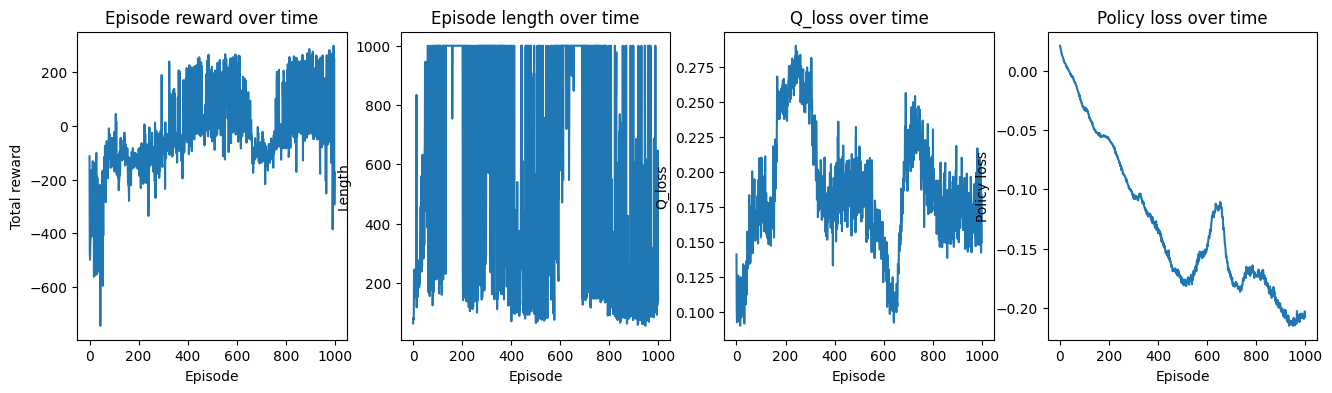

In [53]:
env = create_env("LunarLanderContinuous-v3")
epsilon = 1
n_hidden = 64
lr = 0.001
net = Policy(
    env, epsilon=epsilon, n_hidden=n_hidden, lr=lr, optStep=50, optgamma=0.99, normalize=False
)

gamma = 0.99
n_episode = 1000
batch_size = 256
train_step = 20
explore_steps = 10_000

agent = DDP(
    env, net, gamma, n_episode, batch_size, train_step, explore_steps, log_on_fly=False
)

agent.train()
agent.log()

In [57]:
env = create_env("LunarLanderContinuous-v3", render_mode="rgb_array", record=True, eps_record=1)
agent = DDP(env, net, gamma, n_episode, batch_size, train_step, explore_steps, model_path="/content")
agent.test_agent(2)

>>> Loading policy and Q models...
Average reward: 220.65 - Average length of episodes: 482.0


In [59]:
display_video(1)

## **Twin Delay Deep Deterministic Policy Gradient TDDDPG(TD3)**

- **Twin**
In this method we use two Q_network:
### **Q-learning: Critic**

Loss Functions: Ensure that the critic loss uses the Bellman equation:

$$
\begin{split}
Q_1 & = Q_{1-\text{target}}\bigl(s', \mu_{\theta-\text{target}}(s')\bigr) \\
Q_2 & = Q_{2-\text{target}}\bigl(s', \mu_{\theta-\text{target}}(s')\bigr) \\
Q_{m} & = min(Q_1, Q_2)
\end{split}
$$

<br>

$$
\large L_{\text{critic}} = \mathbb{E}\Biggl[ \Biggl( Q(s, a) - \biggl(r + \gamma Q_{\text{mean}}\biggr) \Biggr)^2 \Biggr]
$$

<br>

```python
Q1 = self.Q1_model(states, actions)
Q2 = self.Q2_model(states, actions)
with torch.no_grad():
    Q1_next = self.Q1_model_target(next_states, self.get_action(next_states, target=True))
    Q2_next = self.Q2_model_target(next_states, self.get_action(next_states, target=True))
    target = rewards + (1 - dones) * gamma * torch.min(Q1_next, Q2_next)
```
<br>

### **Policy-learning: Actor**

The actor Learn deterministic policy, so it loss should maximize the Q-value:

$$
\large L_{\text{actor}} = -\mathbb{E}[ Q(s, \mu_{\theta}(s)) ]
$$

<br>

```python
Q1 = self.Q1_model(states, mu)
Q2 = self.Q2_model(states, mu)
Q = torch.min(Q1, Q2)
```

<br>

- **Delay**

Policy network and target networks will update less frequently compare to Q_models

<br>

>**Note:** we will add noise to target policy output

## **Reparameterization Trick**

[Reference](http://gokererdogan.github.io/2016/07/01/reparameterization-trick/)

it is a technique used in machine learning and variational inference to compute gradients of expectations with respect to the parameters of a probability distribution. This is important when we are optimizing stochastic objectives that depend on sampling from a distribution, as it enables the use of gradient-based optimization methods.

The problem arises when you need to compute the gradient of an expectation:

$$
\min_\theta \mathbb{E}{q_\theta}[f(x)],
$$

where $q_\theta(x)$ is a probability distribution parameterized by $\theta$, and $f(x)$ is a function of the random variable $x$. The expectation depends on $\theta$ both through the distribution $q_\theta(x)$ and possibly through $f(x)$.

The gradient of the expectation is given by:

$$
\nabla_\theta \mathbb{E}{q_\theta}[f(x)].
$$

If you try to compute this, you’d have to backpropagate through the sampling process of  $q_\theta(x)$ , which is non-differentiable. The Reparameterization Trick solves this issue by expressing the random variable  $x$  as a deterministic function of a parameter  $\theta$  and a noise variable  $\epsilon$ , where  $\epsilon$  is independent of  $\theta$.

For example, if  $x \sim q_\theta(x) = \mathcal{N}(\theta, 1)$ (a normal distribution with mean $\theta$ and variance $1$), we can reparameterize  $x4  as:

$$
x = \theta + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 1).
$$

<br>

**Example**
- The distribution is $q_\theta(x) = \mathcal{N}(\theta, 1)$.
- The objective is $\min_\theta \mathbb{E}{q_\theta}[x^2]$.

Using the reparameterization trick, $x = \theta + \epsilon$
> $\epsilon \sim \mathcal{N}(0, 1)$

$$
\mathbb{E}{q_\theta}[x^2] = \mathbb{E}_\epsilon[(\theta + \epsilon)^2].
$$

<br>

- The gradient becomes:

$$
\begin{split}
\nabla_\theta \mathbb{E}{q_\theta}[x^2] & = \nabla_\theta \mathbb{E}_\epsilon[(\theta + \epsilon)^2] \\
& =  \mathbb{E}_\epsilon[2*(\theta + \epsilon)] \\
& = 2\theta
\end{split}
$$

> $\mathbb{E}_\epsilon[\epsilon] = 0$ and  $\mathbb{E}_\epsilon[\epsilon^2] = 1$

### **In RL:**

1. Stochastic Policy Gradients:
The policy is represented as a probability distribution $\pi_\theta(a | s)$ , parameterized by $\theta$. To compute gradients of the expected reward:

$$
\nabla_\theta \mathbb{E}{\pi_\theta}[R],
$$

the reparameterization trick is used to sample actions  a  deterministically as  $a = \mu_\theta(s) + \sigma_\theta(s) \cdot \epsilon$
> $\epsilon \sim \mathcal{N}(0, 1)$. This allows efficient backpropagation through the policy.

2. Exploration:

$$
a = \mu_\theta(s) + \sigma_\theta(s) \cdot \epsilon
$$


In [60]:
class PolicyNetwork(nn.Module):
    """
    A neural network that represents the policy (actor) in DDPG.
    This network maps states to actions in continuous action spaces.
    """

    def __init__(self, n_state, action_dim, action_interval, n_hidden=64, normalize=True):
        """
        Initialize the policy network.

        Args:
            n_state (int): Dimension of the state space.
            action_dim (int): Dimension of the action space (number of action variables).
            action_interval (float): The maximum absolute value for actions (action range: [-action_interval, action_interval]).
            epsilon (float): Standard deviation of exploration noise added to actions for exploration.
            n_hidden (int): Number of hidden units in each layer.
            normalize (bool): Add Layer norm to neural network or not.
        """
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_interval = action_interval
        self.head = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.LayerNorm(n_hidden * 2) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.LayerNorm(n_hidden * 4) if normalize else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.LayerNorm(n_hidden) if normalize else nn.Identity(),
            nn.ReLU()
        )
        self.mu = nn.Linear(n_hidden, action_dim)
        self.log_sigma = nn.Linear(n_hidden, action_dim)

        # Initialize the weights of the network
        self.initialize_weights()

    def initialize_weights(self):
        """
        Initializes the weights of the network using Kaiming normal initialization.
        This initialization is particularly effective with ReLU activations.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, state):
        """
        Forward pass to compute the action.

        Args:
            state (torch.Tensor): The input state tensor of shape (batch_size, n_state).

        Returns:
            torch.Tensor: The action tensor of shape (batch_size, action_dim) with noise added for exploration.
        """
        head = self.head(state)
        mu = torch.tanh(self.mu(head)) * self.action_interval
        log_sigma = self.log_sigma(head)
        sigma = torch.exp(log_sigma)
        return mu , sigma

In [101]:
import itertools

class PolicyDualDelay():
    """
    Deep Q-Network (DQN) implementation.
    """
    def __init__(self, env, epsilon=1, n_hidden=64, lr=0.05,
                 optStep=50, optgamma=0.9, normalize=True):
        """
        Initialize the DQN agent.

        Args:
            env: OpenAI Gym environment.
            n_hidden (int): Number of hidden units in the neural network.
            lr (float): Learning rate for the optimizer.
            optStep (float): Step size factor for learning rate scheduler.
        """
        self.action_dim = env.action_space.shape[0] # Number of possible actions
        self.n_state = env.observation_space.shape[0] # Dimension of state space
        self.action_interval = env.action_space.high[0] # Action bounds
        self.epsilon = epsilon
        self.step = 0
        self.p_loss = 0
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Policy and Q networks
        self.policy_model = PolicyNetwork(self.n_state, self.action_dim, self.action_interval, n_hidden, normalize).to(self.device)
        self.policy_model_target = copy.deepcopy(self.policy_model)

        self.Q1_model = Q_Network(self.n_state, self.action_dim, n_hidden, normalize).to(self.device)
        self.Q1_model_target = copy.deepcopy(self.Q1_model)

        self.Q2_model = Q_Network(self.n_state, self.action_dim, n_hidden, normalize).to(self.device)
        self.Q2_model_target = copy.deepcopy(self.Q2_model)


        # Set up the optimizer and learning rate scheduler
        self.policy_optimizer = torch.optim.Adam(self.policy_model.parameters(), lr)
        self.policy_schedul = torch.optim.lr_scheduler.StepLR(self.policy_optimizer, step_size=optStep, gamma=optgamma)

        self.Q_Network_params = itertools.chain(self.Q1_model.parameters(), self.Q2_model.parameters())
        self.Q_optimizer = torch.optim.Adam(self.Q_Network_params, lr)
        self.Q_schedul = torch.optim.lr_scheduler.StepLR(self.Q_optimizer, step_size=optStep, gamma=optgamma)


    def update_target_network(self, tau=0.99):
        """
        Update the target Q-network using Polyak averaging.

        Args:
            tau (float): Weighting factor for the update (default: 0.01).
        """
        # 𝜙{target} ← 𝜏 * 𝜙{target} + (1 − 𝜏) * 𝜙
        for params, target_params in zip(self.Q1_model.parameters(), self.Q1_model_target.parameters()):
            target_params.data.copy_(tau * target_params.data + (1 - tau) * params.data)

        for params, target_params in zip(self.Q2_model.parameters(), self.Q2_model_target.parameters()):
            target_params.data.copy_(tau * target_params.data + (1 - tau) * params.data)

        for params, target_params in zip(self.policy_model.parameters(), self.policy_model_target.parameters()):
            target_params.data.copy_(tau * target_params.data + (1 - tau) * params.data)

    def get_action(self, states, scale=0.1, target=False, test=False):

        self.policy_model.eval()
        # 𝑎 = 𝜇𝜃(𝑠)
        if target:
            with torch.no_grad():
                mu, sigma = self.policy_model_target(states)
        else:
            mu, sigma = self.policy_model(states)

        self.policy_model.train()

        # Add Gaussian exploration noise for exploration
        noise = torch.normal(0, self.epsilon, mu.size(), device=self.device)
        noise = torch.clamp(noise, -1.0, 1.0)


        if test:
            # 𝑎 = 𝜇𝜃(𝑠) + 𝜎𝜃(𝑠)
            action =  mu + sigma
        else:
            # 𝑎 = 𝜇𝜃(𝑠) + 𝜎𝜃(𝑠) * 𝜖
            action = mu + (sigma * noise * scale) * self.action_interval

        # Ensure the action is within the allowed range
        return action.clamp(-self.action_interval, self.action_interval)


    def Q_net_loss(self, states, actions, rewards, next_states, dones, gamma=0.99, mode = 'huber'):
        """
        Compute the Q-network loss.

        Args:
            states (torch.Tensor): Current states.
            actions (torch.Tensor): Actions taken.
            rewards (torch.Tensor): Rewards received.
            next_states (torch.Tensor): Next states.
            dones (torch.Tensor): Done flags.
            gamma (float): Discount factor.
            mode (str): Loss type ('MSE' or 'Huber').

        Returns:
            torch.Tensor: Q-network loss.
        """
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
        Q1 = self.Q1_model(states, actions)
        Q2 = self.Q2_model(states, actions)
        with torch.no_grad():
            Q1_next = self.Q1_model_target(next_states, self.get_action(next_states, target=True))
            Q2_next = self.Q2_model_target(next_states, self.get_action(next_states, target=True))
            target = rewards + (1 - dones) * gamma * torch.min(Q1_next, Q2_next)

        if mode == 'MSE':
            Q1_loss = nn.functional.mse_loss(Q1, target)
            Q2_loss = nn.functional.mse_loss(Q2, target)
            return (Q1_loss + Q2_loss ) / 2 # Combined loss
        else:
            Q1_loss = nn.functional.smooth_l1_loss(Q1, target)  # Huber loss
            Q2_loss = nn.functional.smooth_l1_loss(Q2, target)  # Huber loss
            return (Q1_loss + Q2_loss ) / 2 # Combined loss



    def policy_loss(self, states, beta=0.1):
        """
        Compute the policy loss.

        Args:
            states (torch.Tensor): Current states.

        Returns:
            torch.Tensor: Policy loss.
        """
        mu , _ = self.policy_model(states)
        Q1 = self.Q1_model(states, mu)
        Q2 = self.Q2_model(states, mu)
        Q = torch.min(Q1, Q2)
        return - beta * Q.mean()


    def update(self, states, actions, rewards, next_states, dones, gamma):
        """
        Update the policy and Q-network.

        Args:
            states (torch.Tensor): Current states.
            actions (torch.Tensor): Actions taken.
            rewards (torch.Tensor): Rewards received.
            next_states (torch.Tensor): Next states.
            dones (torch.Tensor): Done flags.
            gamma (float): Discount factor.
        """
        self.step += 1

        # Update Q-network
        Q_loss = self.Q_net_loss(states, actions, rewards, next_states, dones, gamma)
        self.Q_optimizer.zero_grad()
        Q_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.Q_Network_params, max_norm=0.5)  # Gradient clipping
        self.Q_optimizer.step()

        # Policy network and target networks will update less frequently compare to Q_models
        if self.step % 2 == 0:
            # Freeze Q-network
            for params in self.Q_Network_params:
                params.requires_grad = False

            # Backpropagate and update the policy model
            p_loss = self.policy_loss(states)
            self.policy_optimizer.zero_grad()
            p_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), max_norm=0.5)  # Gradient clipping
            self.policy_optimizer.step()
            self.p_loss = p_loss
            # Unfreeze Q-network
            for params in self.Q_Network_params:
                params.requires_grad = True

            self.update_target_network()

        return Q_loss, self.p_loss


In [107]:
class DDP():
    def __init__(self, env, network, gamma=0.99, n_episode=1000, batch_size=256,
                 train_step=20, explore_steps=10_000, model_path=None, log_on_fly=True):
        # Initialize the class with essential hyperparameters and environment details

        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

        # Environment and agent parameters
        self.env = env  # Gym environment
        self.network = network  # Policy and Q-network (actor-critic)
        self.gamma = gamma  # Discount factor for rewards
        self.n_episode = n_episode  # Total number of training episodes
        self.epsilon_min = 0.1  # Minimum exploration probability (epsilon)
        self.decay_rate = 0.0001  # Decay rate for epsilon
        self.epi = 0  # Current episode index
        self.capacity = 5 * explore_steps
        self.buffer = ReplayBuffer(self.capacity)  # Replay buffer to store experiences
        self.batch_size = batch_size  # Batch size for training
        self.explore_steps = explore_steps  # Number of steps for initial exploration
        self.train_step = train_step  # Number of training updates per episode

        # Metrics to track training progress
        self.length_episode = []  # Stores episode lengths
        self.total_reward_episode = []  # Stores total rewards for each episode
        self.Q_losses = []  # Stores Q-network losses
        self.policy_losses = []  # Stores policy network losses
        self.log_on_fly = log_on_fly  # Whether to log progress during training
        self.best_reward = float('-inf') # Track the best reward achieved during training


        # Load pretrain model, if any..
        if model_path:
            self.load(model_path)
        else:
            # Ensure the replay buffer is filled with enough samples before training
            with tqdm(total=explore_steps, desc="Filling replay buffer") as pbar:
                while len(self.buffer) < explore_steps:
                    current_size = len(self.buffer)
                    self.play()  # Collect more samples
                    new_size = len(self.buffer)
                    pbar.update(new_size - current_size)  # Update progress
                    pbar.set_postfix({"Current": len(self.buffer), "Target": explore_steps})

    def load(self, path):

        policy_path = os.path.join(path, 'model_policy_net.pth')
        q_path = os.path.join(path, 'model_q_net.pth')

        if os.path.isfile(policy_path) and os.path.isfile(q_path):
            print('>>> Loading policy and Q models...')

            checkpoint = torch.load(policy_path, map_location=self.device)
            self.network.policy_model.load_state_dict(checkpoint['model_state_dict'])
            self.network.policy_model_target.load_state_dict(checkpoint['model_target_state_dict'])
            self.network.policy_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.network.policy_schedul.load_state_dict(checkpoint['lr_sched_state_dict'])

            checkpoint2 = torch.load(q_path, map_location=self.device)
            self.network.Q1_model.load_state_dict(checkpoint2['model1_state_dict'])
            self.network.Q1_model_target.load_state_dict(checkpoint2['model1_target_state_dict'])

            self.network.Q2_model.load_state_dict(checkpoint2['model2_state_dict'])
            self.network.Q2_model_target.load_state_dict(checkpoint2['model2_target_state_dict'])

            self.network.Q_optimizer.load_state_dict(checkpoint2['optimizer_state_dict'])
            self.network.Q_schedul.load_state_dict(checkpoint2['lr_sched_state_dict'])

    def sample(self, index=False):
        # Sample a batch of experiences from the replay buffer
        sample_size = min(len(self.buffer), self.batch_size)
        states, actions, rewards, next_states, dones = self.buffer.sample(sample_size)

        # Convert states and actions to PyTorch tensors
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.float32).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones.astype('float32')).to(self.device)

        return states, actions, rewards, next_states, dones

    def test_agent(self, num_test_episodes):

        # Evaluate the agent's performance over a specified number of test episodes
        ep_rets, ep_lens = [], []  # Episode returns and lengths
        for j in range(num_test_episodes):
            state, _ = self.env.reset()  # Reset the environment
            done, rewards, length = False, 0, 0

            while not done:
                state = torch.tensor(state, dtype=torch.float32).to(self.device)
                # Take deterministic actions during testing
                with torch.no_grad():
                    action = self.network.get_action(torch.tensor(state, device=self.device), test=True).detach().cpu().numpy()

                    # action = self.network.policy_model(state)[0].detach().cpu().numpy()

                state, reward, done, _ = self.env.step(action)
                rewards += reward
                length += 1

            ep_rets.append(rewards)  # Record the total reward
            ep_lens.append(length)  # Record the episode length

        print(f"Average reward: {np.mean(ep_rets):.2f} - "
              f"Average length of episodes: {np.mean(ep_lens)}")  # print average reward and length

    def train(self):
        """
        Train the agent using the DDP algorithm.
        """
        print(f"Available device: {self.device} - Highest possible score: {self.env.spec.reward_threshold}")
        pbar = tqdm(range(self.n_episode), desc = "Episode")  # Progress bar for training episodes

        for episode in pbar:
            # Play one episode and collect trajectory data
            self.play(train=True)

            # Perform multiple training updates
            q_loss, p_loss = 0, 0
            for _ in range(self.train_step):
                # Sample a batch of experiences
                states, actions, rewards, next_states, dones = self.sample()
                # Update the policy and Q-networks
                q_l, p_l = self.network.update(states, actions, rewards, next_states, dones, self.gamma)
                q_loss += (q_l / self.train_step)  # Average Q-loss
                p_loss += (p_l / self.train_step)  # Average policy loss

            self.Q_losses.append(q_loss.detach().cpu().numpy())  # Record Q-loss
            self.policy_losses.append(p_loss.detach().cpu().numpy())  # Record policy loss

            # Update epsilon and learning rates after every 5 episodes
            if episode% 5 == 0 and episode > 0:
                self.network.epsilon = max(self.epsilon_min, self.network.epsilon * np.exp(-self.decay_rate * episode))

            self.network.policy_schedul.step()  # Update policy learning rate
            self.network.Q_schedul.step()  # Update Q-learning rate

            if self.log_on_fly and (episode % 3 == 0):
                self.log()

            # Update the progress bar with learning rate and recent average rewards
            avg_reward = np.mean(self.total_reward_episode[max(0, episode - 5):episode])
            pbar.set_postfix({
                " Avg reward": f"{avg_reward:.2f}",
                " Policy Loss": f"{p_loss:.4f}",
                " Q Loss": f"{q_loss:.4f}",
                " α Neural Network": f"{self.network.policy_optimizer.param_groups[0]['lr']:.6f}",
                " 𝜖": f"{self.network.epsilon:.2f}",
                "Reply buffer filling": f"{len(self.buffer) / self.capacity * 100:.2f} %"
            })

            # Save the model best reward
            if avg_reward >= self.best_reward:
                self.best_reward = avg_reward

                torch.save(
                    {
                        'model_state_dict': self.network.policy_model.state_dict(),
                        'model_target_state_dict': self.network.policy_model_target.state_dict(),
                        'optimizer_state_dict': self.network.policy_optimizer.state_dict(),
                        'lr_sched_state_dict': self.network.policy_schedul.state_dict()
                    }, 'model_policy_net.pth'
                )

                torch.save(
                    {
                        'model1_state_dict': self.network.Q1_model.state_dict(),
                        'model1_target_state_dict': self.network.Q1_model_target.state_dict(),
                        'model2_state_dict': self.network.Q2_model.state_dict(),
                        'model2_target_state_dict': self.network.Q2_model_target.state_dict(),
                        'optimizer_state_dict': self.network.Q_optimizer.state_dict(),
                        'lr_sched_state_dict': self.network.Q_schedul.state_dict()
                    }, 'model_q_net.pth'
                )

        print(f"Best reward: {self.best_reward}")

    def play(self, train=False):
        """
        Play one episode of the environment.

        Args:
            train (bool): If True, track episode statistics and update the learning schedule.
        """
        state, _ = self.env.reset()  # Reset the environment
        length_episode = 0  # Track the episode length
        total_reward_episode = 0  # Track total rewards for the episode
        done = False

        while not done:
            # Choose action based on exploration or policy
            if train:
                action = self.network.get_action(torch.tensor(state, device=self.device)).detach().cpu().numpy()
            else:
                action = self.env.action_space.sample()  # Random action for exploration

            # Perform action and observe the environment's response
            next_state, reward, done, _ = self.env.step(action)

            # Update episode statistics during training
            if train:
                length_episode += 1
                total_reward_episode += reward

            # Store the transition in the replay buffer
            self.buffer.append((state, action, reward, next_state, done))

            state = next_state  # Move to the next state

        # Track episode metrics during training
        if train:
            self.epi += 1
            self.length_episode.append(length_episode)
            self.total_reward_episode.append(total_reward_episode)


    def log(self):
        """
        Log training statistics and plot metrics.
        """
        if self.log_on_fly:
            clear_output(True)

        fig = plt.figure(figsize=(16, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 4, 1)
        plt.plot(self.total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 4, 2)
        plt.plot(self.length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        # Plot Q-loss over episodes
        fig.add_subplot(1, 4, 3)
        plt.plot(self.Q_losses)
        plt.title('Q_loss over time')
        plt.xlabel('Episode')
        plt.ylabel('Q_loss')

        # Plot policy loss over episodes
        fig.add_subplot(1, 4, 4)
        plt.plot(self.policy_losses)
        plt.title('Policy loss over time')
        plt.xlabel('Episode')
        plt.ylabel('Policy loss')

        # Display current training progress
        if self.log_on_fly:
            avg_reward = np.mean(self.total_reward_episode[max(0, self.epi - 50):self.epi + 1])
            fig.suptitle(f"Episode: {self.epi+1} |"
                        f"α Neural network: {round(self.network.policy_optimizer.param_groups[0]['lr'], 6)} |"
                        f" Avg Reward: {avg_reward:.2f} |"
                        f" Epsilon: {self.network.epsilon:.2f}")
        plt.show()

Filling replay buffer:   0%|          | 0/10000 [00:00<?, ?it/s]

Available device: cuda - Highest possible score: 200


Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Best reward: 218.5049431019898


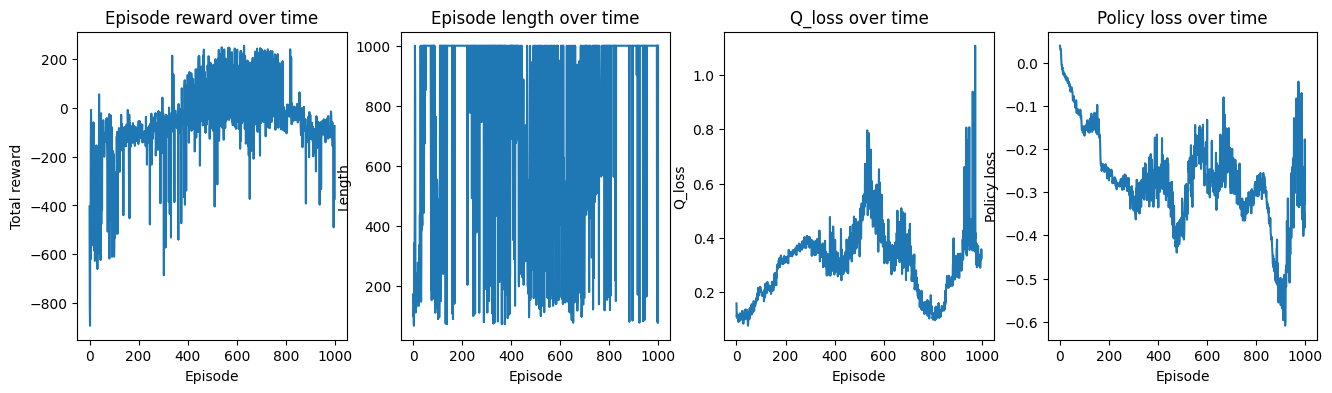

In [112]:
env = create_env("LunarLanderContinuous-v3")
epsilon = 1
n_hidden = 64
lr = 0.0012
net = PolicyDualDelay(
    env, epsilon=epsilon, n_hidden=n_hidden, lr=lr, optStep=50, optgamma=0.95, normalize=False
)

gamma = 0.99
n_episode = 1000
batch_size = 256
train_step = 20
explore_steps = 10_000

agent = DDP(
    env, net, gamma, n_episode, batch_size, train_step, explore_steps, log_on_fly=False
)

agent.train()
agent.log()

Filling replay buffer:   0%|          | 0/10000 [00:00<?, ?it/s]

Available device: cuda - Highest possible score: 200


Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

Best reward: 90.04956699193733


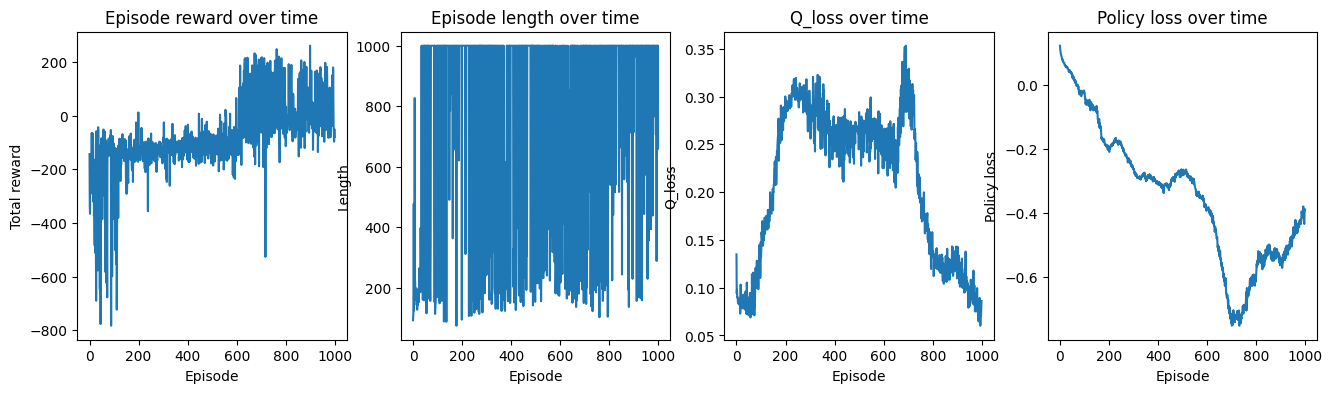

In [103]:
env = create_env("LunarLanderContinuous-v3")
epsilon = 1
n_hidden = 64
lr = 0.001
net = PolicyDualDelay(
    env, epsilon=epsilon, n_hidden=n_hidden, lr=lr, optStep=50, optgamma=0.95, normalize=False
)

gamma = 0.99
n_episode = 1000
batch_size = 256
train_step = 20
explore_steps = 10_000

agent = DDP(
    env, net, gamma, n_episode, batch_size, train_step, explore_steps, log_on_fly=False
)

agent.train()
agent.log()